#### Regression coefficient analysis

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
import os
import scipy
from scipy.optimize import curve_fit
from scipy.stats import linregress
import glob
import pathlib
from pathlib import Path
import re 
import sys
from pynwb import NWBHDF5IO
import shutil
import time
from IPython.display import display, HTML

sys.path.insert(1, '/root/capsule/code/utils')
import behavior_utils as bu
import array_utils as au


import joblib
from joblib import Memory

file_path = '/root/capsule/data/foraging_nwb_bonsai_processed/662914_2023-09-22/662914_2023-09-22_df_session_logistic_regression_df_beta_Su2022.pkl'

In [5]:
with open(file_path, 'rb') as file:
    data = pickle.load(file)
print(data.shape)

(1, 31)


In [6]:
# Load in session DataFrame
folder = '/root/capsule/data/filtered_data_session/filtered_data_20241107.csv'
session_df = pd.read_csv(folder)

/tmp/ipykernel_16581/2073535739.py:3: DtypeWarning: Columns (6,7,8,11,26,27,28,29,30,133,134,149,150,151,152,153,154,155,156,157,158,159,160,161) have mixed types. Specify dtype option on import or set low_memory=False.
  session_df = pd.read_csv(folder)


In [7]:
print(data.info())
print(data.index.names)
print(data.columns.names)

for name in data.index.names:
    print(f"Unique values in {name}:", data.index.get_level_values(name).unique())

for name in data.columns.names:
    print(f"Unique values in {name}:", data.columns.get_level_values(name).unique())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1 entries, ('662914', '2023-09-22', 0) to ('662914', '2023-09-22', 0)
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   (RewC, 15.0)  1 non-null      float64
 1   (RewC, 14.0)  1 non-null      float64
 2   (RewC, 13.0)  1 non-null      float64
 3   (RewC, 12.0)  1 non-null      float64
 4   (RewC, 11.0)  1 non-null      float64
 5   (RewC, 10.0)  1 non-null      float64
 6   (RewC, 9.0)   1 non-null      float64
 7   (RewC, 8.0)   1 non-null      float64
 8   (RewC, 7.0)   1 non-null      float64
 9   (RewC, 6.0)   1 non-null      float64
 10  (RewC, 5.0)   1 non-null      float64
 11  (RewC, 4.0)   1 non-null      float64
 12  (RewC, 3.0)   1 non-null      float64
 13  (RewC, 2.0)   1 non-null      float64
 14  (RewC, 1.0)   1 non-null      float64
 15  (UnrC, 15.0)  1 non-null      float64
 16  (UnrC, 14.0)  1 non-null      float64
 17  (UnrC, 13.0)  1 non-null 

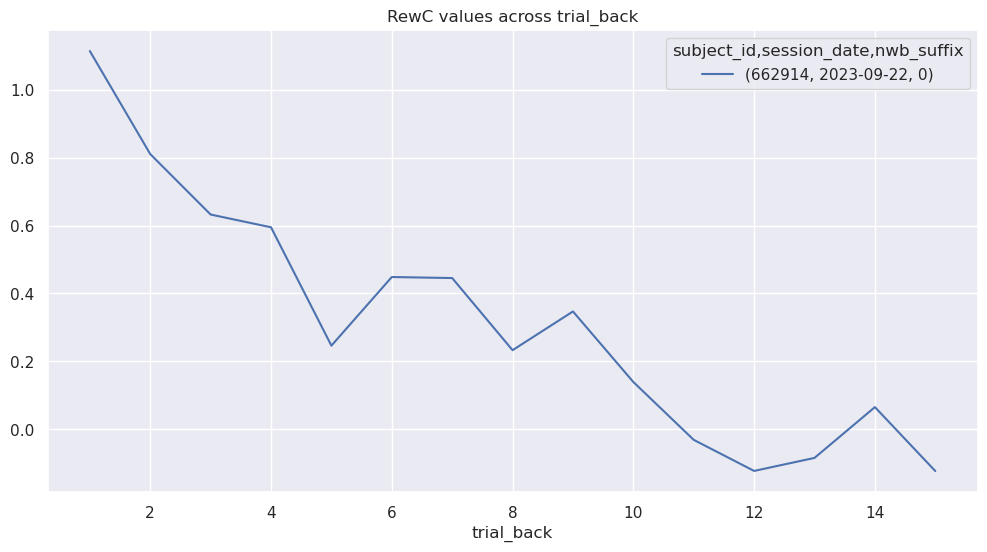

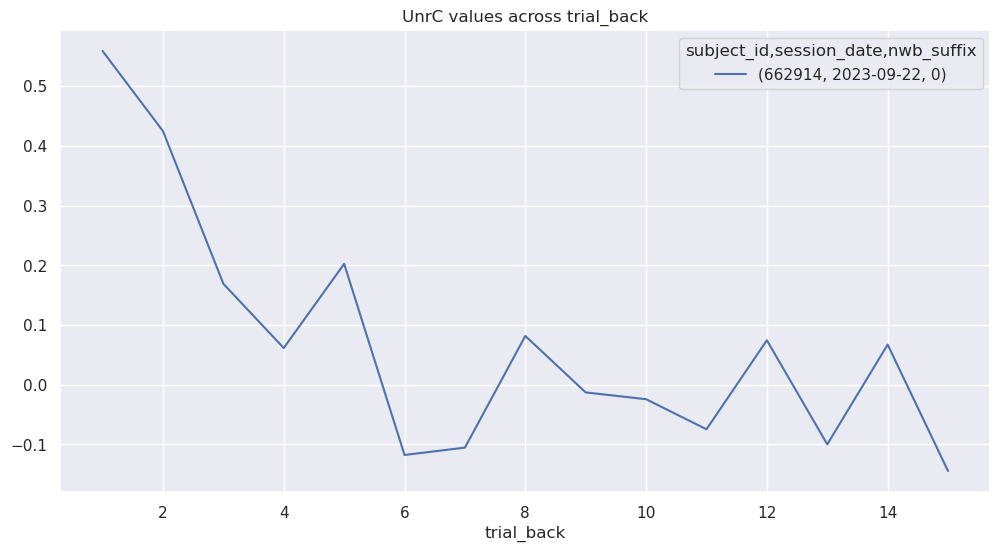

None


In [12]:

sns.set_theme()

# Plot Rewarded Choice
data['RewC'].T.plot(figsize=(12, 6))
plt.title('RewC values across trial_back')
plt.show()

# Plot Unrewarded Choice
data['UnrC'].T.plot(figsize=(12, 6))
plt.title('UnrC values across trial_back')
plt.show()

x = data['UnrC'].values.tolist()

print(x.reverse())

In [6]:
# folder = '/root/capsule/scratch'
# for filename in os.listdir(folder):
#     file_path = os.path.join(folder, filename)
#     try:
#         if os.path.isfile(file_path) or os.path.islink(file_path):
#             os.unlink(file_path)
#         elif os.path.isdir(file_path):
#             shutil.rmtree(file_path)
#     except Exception as e:
#         print('Failed to delete %s. Reason: %s' % (file_path, e))

In [7]:
cachedir = '/root/capsule/scratch'
memory = Memory(cachedir, verbose=0)

@memory.cache
def process_single_dataset(pkl_file_path): 
    """ 
    Process single pkl dataset and extract values

    Params:
    pkl_file_path (str or Path): Path to the pkl file 
    """ 
    try:
        # Load pkl and extract values
        with open(pkl_file_path, 'rb') as file:
            df = pickle.load(file) 

        rewc_values = {}
        unrc_values = {}

        for trial_back in range(1,16):
            rewc_values[trial_back] = df[('RewC', trial_back)].iloc[0]
            unrc_values[trial_back] = df[('UnrC', trial_back)].iloc[0]

        results_df = pd.DataFrame({
            'trial_back': range(1,16),
            'RewC': [rewc_values[i] for i in range(1,16)],
            'UnrC': [unrc_values[i] for i in range(1,16)]
        })

        # Get subject_id and session_date
        parts = pkl_file_path.stem.split('_')
        subject_id = parts[0]
        session_date = parts[1]

        # Save extracted values to output directory
        output_file = Path('/root/capsule/scratch') / f'{subject_id}_{session_date}.csv'
        results_df.to_csv(output_file, index=False)
        print(f'Successfully processed: {pkl_file_path.name}')

    except (KeyError, IndexError) as e:
        print(f'Error processing: {pkl_file_path.name}: {str(e)}')

In [8]:
base_dir = Path('/root/capsule/data/foraging_nwb_bonsai_processed')
pkl_files = [f for f in base_dir.glob('*/*_df_session_logistic_regression_df_beta_Su2022.pkl') if f.is_file()]

for pkl_file in pkl_files:
    process_single_dataset(pkl_file)

KeyboardInterrupt: 

In [16]:
# Filename metadata extraction 

def extract_metadata_from_filename(file_path): 
    filename = file_path.split('/')[-1]
    match = re.match(r'(\d{6})_(\d{4}-\d{2}-\d{2})\.csv$', filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

In [17]:
# Create master DataFrame

csv_files = glob.glob('/root/capsule/scratch/*.csv')

dataframes = []

for file in csv_files:
    filename = file.split('/')[-1]

    if not re.match(r'\d{6}_\d{4}-\d{2}-\d{2}\.csv$', filename):
        print(f'FIP trial: skipping {filename}')
        continue

    try: 
        df = pd.read_csv(file)
        df.columns = df.columns.str.strip()
        df.columns = df.columns.str.replace(r'[^a-zA-Z0-9_]', '', regex=True)  # Remove special characters

        # Extract subject_id, session_date from metadata 
        subject_id, session_date = extract_metadata_from_filename(file)

        if subject_id is None or session_date is None:
            print(f'Could not extract metada from {filename}')
            continue
    
        df['subject_id'] = subject_id
        df['session_date'] = session_date

        dataframes.append(df)
    except Exception as e:
        print(f'Error processing {file}: {e}')

combined_df = pd.concat(dataframes, ignore_index=True)
combined_df['subject_id'] = pd.to_numeric(combined_df['subject_id'], errors='coerce')


FIP trial: skipping 744330_2024-10-03_fip_trials.csv
FIP trial: skipping 757129_2024-10-18_fip_trials.csv
FIP trial: skipping 748387_2024-10-21_fip_trials.csv
FIP trial: skipping 744331_2024-10-11_fip_trials.csv
FIP trial: skipping 726441_2024-09-26_fip_trials.csv
FIP trial: skipping 746716_2024-10-18_fip_trials.csv
FIP trial: skipping 724910_2024-09-27_fip_trials.csv
FIP trial: skipping 726649_2024-10-15_fip_trials.csv
FIP trial: skipping 744744_2024-09-20_fip_trials.csv
FIP trial: skipping 711041_2024-08-12_fip_trials.csv
FIP trial: skipping 757128_2024-09-20_fip_trials.csv
FIP trial: skipping 750102_2024-08-20_fip_trials.csv
FIP trial: skipping 750997_2024-10-21_fip_trials.csv
FIP trial: skipping 746716_2024-10-09_fip_trials.csv
FIP trial: skipping 750101_2024-08-30_fip_trials.csv
FIP trial: skipping 708027_2024-08-09_fip_trials.csv
FIP trial: skipping 750997_2024-10-03_fip_trials.csv
FIP trial: skipping 757129_2024-10-09_fip_trials.csv
FIP trial: skipping 744742_2024-09-13_fip_tria

In [18]:
combined_df

,trial_back,RewC,UnrC,subject_id,session_date
0,1,2.581842,2.012005,717617,2024-06-20
1,2,0.878633,0.305734,717617,2024-06-20
2,3,0.664607,-0.089655,717617,2024-06-20
3,4,-0.411080,-0.453087,717617,2024-06-20
4,5,-0.338984,0.339820,717617,2024-06-20
...,...,...,...,...,...
80830,11,1.128650,-0.861296,668551,2023-10-05
80831,12,0.565511,-0.401688,668551,2023-10-05
80832,13,-0.526585,0.405658,668551,2023-10-05
80833,14,-0.209592,-0.197963,668551,2023-10-05


In [24]:
def average_across_three_sessions(df):
    """
    Average RewC and UnrC across every 3 sessions for each subject,
    using the maximum number of divisible sessions.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe with columns: trial_back, RewC, UnrC, subject_id, session_date
    
    Returns:
    --------
    pandas.DataFrame
        Averaged dataframe with RewC and UnrC values aggregated across sets of 3 sessions
    """
    # Group sessions by subject_id and sort by session_date
    df_sorted = df.sort_values(['subject_id', 'session_date'])
    
    # Create a list to store processed dataframes
    processed_subjects = []
    
    # Process each unique subject
    for subject, subject_data in df_sorted.groupby('subject_id'):
        # Count total unique sessions for this subject
        total_sessions = subject_data['session_date'].nunique()
        
        # Skip subjects with fewer than 3 sessions
        if total_sessions < 3:
            continue
        
        # Calculate maximum number of complete 3-session sets
        num_sets = total_sessions // 3
        
        # Prepare the data for this subject
        subject_processed = []
        
        # Iterate through sets of 3 sessions
        for set_num in range(num_sets):
            # Select the subset of data for this 3-session set
            start_index = set_num * 3
            end_index = start_index + 3
            
            # Get the sessions for this subset
            subset_sessions = subject_data['session_date'].unique()[start_index:end_index]
            
            # Filter data for these specific sessions
            subset_data = subject_data[subject_data['session_date'].isin(subset_sessions)].copy()
            
            # Average RewC and UnrC for each trial_back
            averaged_subset = subset_data.groupby('trial_back').agg({
                'RewC': 'mean',
                'UnrC': 'mean'
            }).reset_index()
            
            # Add subject and set information
            averaged_subset['subject_id'] = subject
            averaged_subset['session_group'] = set_num
            
            subject_processed.append(averaged_subset)
        
        # Combine sets for this subject
        if subject_processed:
            processed_subjects.append(pd.concat(subject_processed))
    
    # Combine data for all subjects
    if processed_subjects:
        return pd.concat(processed_subjects)[['subject_id', 'session_group', 'trial_back', 'RewC', 'UnrC']]
    else:
        return pd.DataFrame(columns=['subject_id', 'session_group', 'trial_back', 'RewC', 'UnrC'])


In [27]:
df_result = average_across_three_sessions(combined_df)

TypeError: 'DataFrame' object is not callable

In [28]:
df_result.head(60)

,subject_id,session_group,trial_back,RewC,UnrC
0,662914,0,1,1.900062,0.864147
1,662914,0,2,0.963845,0.416216
2,662914,0,3,0.539597,0.275067
3,662914,0,4,0.595258,0.257858
4,662914,0,5,0.347383,0.311643
5,662914,0,6,0.383770,-0.121041
6,662914,0,7,0.188101,0.190311
7,662914,0,8,-0.037121,0.069855
8,662914,0,9,-0.171330,-0.135621
9,662914,0,10,0.470296,0.145487


trial back values: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15], 
 RewC values: [ 1.38778895  0.72609861  0.44358104  0.28541924  0.20890623  0.15273641
  0.11134044  0.07338134  0.05587062  0.03121622  0.02789095 -0.00327989
 -0.00306504 -0.01529575 -0.02935909], 
 UnrC values: [ 0.75790416  0.21910217  0.08293743  0.01826997  0.00283154 -0.01378577
 -0.00313806 -0.01791232 -0.01539264 -0.01822323 -0.00341342 -0.00813155
 -0.00282496 -0.01890438 -0.02252601]


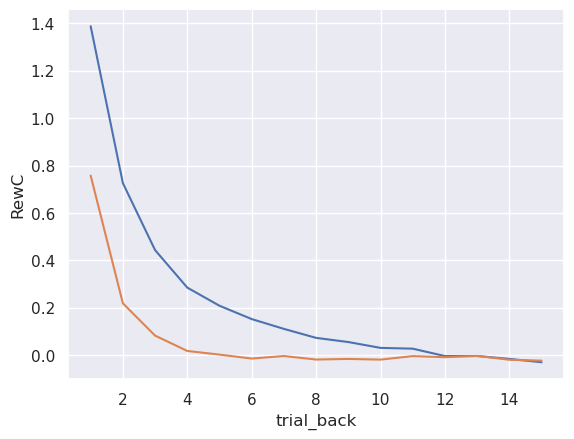

In [44]:
trial_back_df = df_result.groupby('trial_back', as_index=False)[['RewC', 'UnrC']].mean()
trial_back_df

sns.lineplot(trial_back_df, x='trial_back', y='RewC')
sns.lineplot(trial_back_df, x='trial_back', y='UnrC')

x = trial_back_df['trial_back'].values
y = trial_back_df['RewC'].values
y_unrc = trial_back_df['UnrC'].values

print(f'trial back values: {x}, \n RewC values: {y_rewc}, \n UnrC values: {y_unrc}')

Regression Analysis Results:

Linear:
R-squared: 0.6094
Parameters: [-0.06642138  0.69516499]

Quadratic:
R-squared: 0.8652
Parameters: [ 0.01121194 -0.22338855  1.03526053]

Cubic:
R-squared: 0.9606
Parameters: [-0.00183776  0.04980491 -0.43215813  1.23594396]

Exponential:
Error: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

Logarithmic:
R-squared: 0.8908
Parameters: [-0.4592798   1.08445348]


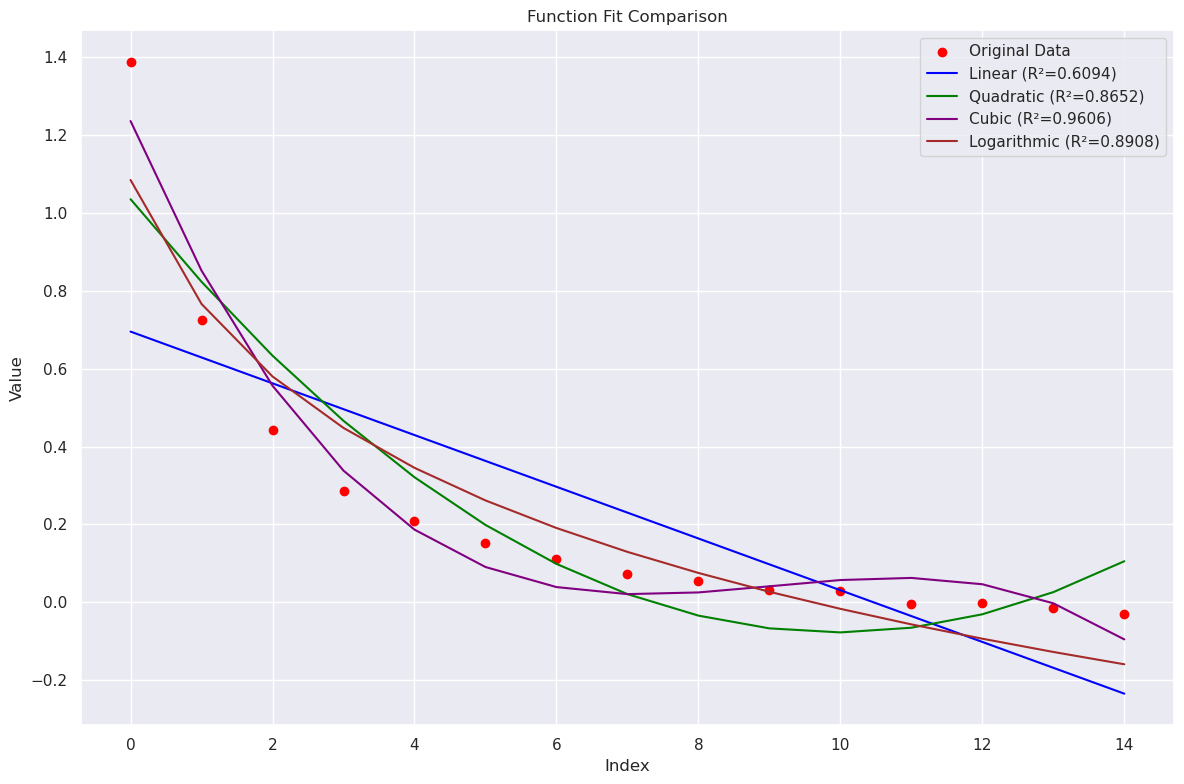

In [49]:
from sklearn.metrics import r2_score
data = trial_back_df['RewC'].values

x = np.arange(len(data))
y = np.array(data)

# Define function types for fitting
def linear(x, a, b):
    return a * x + b

def quadratic(x, a, b, c):
    return a * x**2 + b * x + c

def cubic(x, a, b, c, d):
    return a * x**3 + b * x**2 + c * x + d

def exponential(x, a, b, c):
    return a * np.exp(b * x) + c

def logarithmic(x, a, b):
    return a * np.log(x + 1) + b

# Perform curve fitting and calculate R-squared for each function
functions = {
    'Linear': linear,
    'Quadratic': quadratic,
    'Cubic': cubic,
    'Exponential': exponential,
    'Logarithmic': logarithmic
}

results = {}

for name, func in functions.items():
    try:
        # Determine number of parameters for curve_fit
        if name == 'Linear':
            popt, _ = curve_fit(func, x, y, p0=[1, 0])
        elif name == 'Quadratic':
            popt, _ = curve_fit(func, x, y, p0=[1, 0, 0])
        elif name == 'Cubic':
            popt, _ = curve_fit(func, x, y, p0=[1, 0, 0, 0])
        elif name == 'Exponential':
            popt, _ = curve_fit(func, x, y, p0=[1, 0.1, 0])
        elif name == 'Logarithmic':
            popt, _ = curve_fit(func, x, y, p0=[1, 0])
        
        # Calculate fitted values
        y_fit = func(x, *popt)
        
        # Calculate R-squared
        r2 = r2_score(y, y_fit)
        results[name] = {
            'R-squared': r2,
            'Parameters': popt
        }
    except Exception as e:
        results[name] = {'Error': str(e)}

# Print results
print("Regression Analysis Results:")
for name, result in results.items():
    print(f"\n{name}:")
    if 'R-squared' in result:
        print(f"R-squared: {result['R-squared']:.4f}")
        print("Parameters:", result['Parameters'])
    else:
        print("Error:", result['Error'])

# Plotting
plt.figure(figsize=(12, 8))
plt.scatter(x, y, label='Original Data', color='red')

# Plot fitted curves
colors = ['blue', 'green', 'purple', 'orange', 'brown']
for (name, result), color in zip(results.items(), colors):
    if 'R-squared' in result:
        func = functions[name]
        plt.plot(x, func(x, *result['Parameters']), 
                 label=f'{name} (R²={result["R-squared"]:.4f})', 
                 color=color)

plt.title('Function Fit Comparison')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

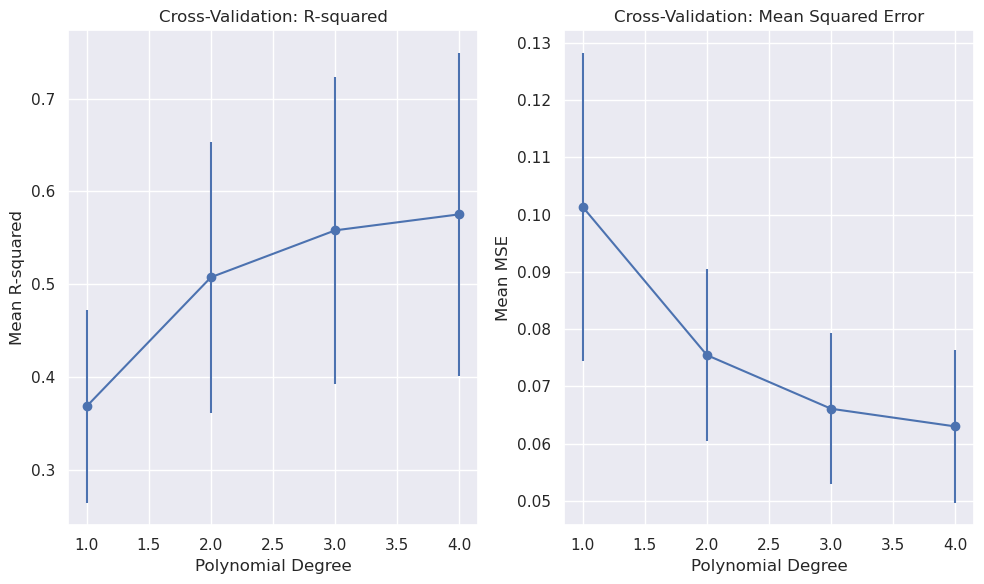

In [53]:

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

def fit_polynomial(x, y, degree):
    """Fit polynomial of specified degree"""
    return np.polyfit(x, y, degree)

def polynomial_func(x, coeffs):
    """Generate polynomial function from coefficients"""
    return np.polyval(coeffs, x)

def cross_validate_polynomial(df, target_col='RewC', x_col='trial_back'):
    """
    Perform cross-validation across session groups
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe with session groups
    target_col : str
        Column to fit (default 'RewC')
    x_col : str
        Column to use as x-axis (default 'trial_back')
    
    Returns:
    --------
    dict: Performance metrics for different polynomial degrees
    """
    # Unique session groups
    session_groups = df['session_group'].unique()
    
    # Degrees to test
    degrees = [1, 2, 3, 4]
    
    # Store results
    cv_results = {degree: [] for degree in degrees}
    
    # Cross-validation
    for test_group in session_groups:
        # Split data
        test_data = df[df['session_group'] == test_group]
        train_data = df[df['session_group'] != test_group]
        
        # Prepare data
        x_train = train_data[x_col].values
        y_train = train_data[target_col].values
        x_test = test_data[x_col].values
        y_test = test_data[target_col].values
        
        # Fit and evaluate different polynomial degrees
        for degree in degrees:
            # Fit polynomial on training data
            coeffs = fit_polynomial(x_train, y_train, degree)
            
            # Predict on test data
            y_pred = polynomial_func(x_test, coeffs)
            
            # Calculate R-squared and MSE
            r2 = r2_score(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            
            cv_results[degree].append({
                'R-squared': r2,
                'MSE': mse
            })
    
    # Summarize results
    summary = {}
    for degree, results in cv_results.items():
        r2_scores = [r['R-squared'] for r in results]
        mse_scores = [r['MSE'] for r in results]
        
        summary[degree] = {
            'Mean R-squared': np.mean(r2_scores),
            'R-squared Std': np.std(r2_scores),
            'Mean MSE': np.mean(mse_scores),
            'MSE Std': np.std(mse_scores)
        }
    
    return summary

# Visualization function
def plot_cross_validation_results(summary):
    plt.figure(figsize=(10, 6))
    
    # R-squared plot
    plt.subplot(1, 2, 1)
    degrees = list(summary.keys())
    mean_r2 = [summary[d]['Mean R-squared'] for d in degrees]
    std_r2 = [summary[d]['R-squared Std'] for d in degrees]
    
    plt.errorbar(degrees, mean_r2, yerr=std_r2, fmt='o-')
    plt.title('Cross-Validation: R-squared')
    plt.xlabel('Polynomial Degree')
    plt.ylabel('Mean R-squared')
    
    # MSE plot
    plt.subplot(1, 2, 2)
    mean_mse = [summary[d]['Mean MSE'] for d in degrees]
    std_mse = [summary[d]['MSE Std'] for d in degrees]
    
    plt.errorbar(degrees, mean_mse, yerr=std_mse, fmt='o-')
    plt.title('Cross-Validation: Mean Squared Error')
    plt.xlabel('Polynomial Degree')
    plt.ylabel('Mean MSE')
    
    plt.tight_layout()
    plt.show()

# Usage example (you would replace this with your actual dataframe)
results = cross_validate_polynomial(df_result)
plot_cross_validation_results(results)

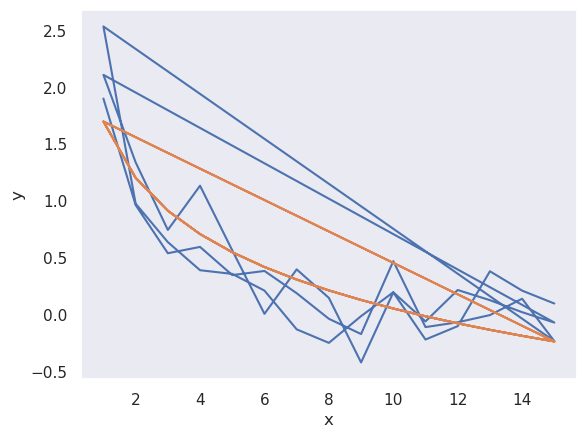

In [35]:
subject = 662914

test_sample = df_result[df_result['subject_id'] == subject]

x = test_sample['trial_back'].values
y = test_sample['RewC'].values

def neg_log(x, a, b):
    return -a*np.log(x) + b

constants = curve_fit(neg_log, x, y)
a_fit = constants[0][0]
b_fit = constants[0][1]

fit = []
for i in x:
    fit.append(neg_log(i, a_fit, b_fit))

plt.plot(x, y)
plt.plot(x, fit)
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [43]:
# Regression slope calculation 

def calculate_slope(df, trial_back_n):
    """ 
    Calculate slope of regression line for first n trial_back values for each subject_id session_date pair

    Params: 
    df (DataFrame): Input regression coefficient DataFrame with RewC and UnrC beta coefficient values 
    trial_back_n (int): Number of past trials to be included in regression 

    Returns:
    result_df (DataFrame): DataFrame with subject_id, session_date, and slope columns 
    """ 

    # Initialize results 
    results = []

    # Group by subject and session date
    grouped = df.groupby(['subject_id', 'session_date'])

    for (subject_id, session_date), group in grouped:
        group = group.sort_values(by='trial_back')

        first_n = group.head(trial_back_n)

        if len(first_n) < trial_back_n: 
            continue

        # Extract trial back and coefficient values
        x = first_n['trial_back']

        # Calculate slope for RewC
        y_rewc = first_n['RewC']
        slope_rewc = np.polyfit(x, y_rewc, 1)[0]

        # Calculate slope for RewC
        y_unrc = first_n['UnrC']
        slope_unrc = np.polyfit(x, y_unrc, 1)[0]

        results.append({
            'subject_id': subject_id,
            'session_date': session_date,
            'slope_RewC': slope_rewc,
            'slope_UnrC': slope_unrc
        })

    result_df = pd.DataFrame(results)
    return result_df

In [44]:
slope_df = calculate_slope(combined_df, trial_back_n = 2)

slope_df

,subject_id,session_date,slope_RewC,slope_UnrC
0,662914,2023-09-19,-0.651586,-0.507835
1,662914,2023-09-21,-1.853889,-0.701837
2,662914,2023-09-22,-0.303175,-0.134120
3,662914,2023-09-25,-1.161310,-0.705931
4,662914,2023-09-29,-0.979688,-0.414583
...,...,...,...,...
5384,769887,2024-11-06,0.004976,-0.168317
5385,769888,2024-11-04,0.348915,0.112820
5386,769888,2024-11-07,-1.671448,-0.399860
5387,769888,2024-11-08,-0.001002,-0.001097


<Axes: xlabel='session_date', ylabel='slope_RewC'>

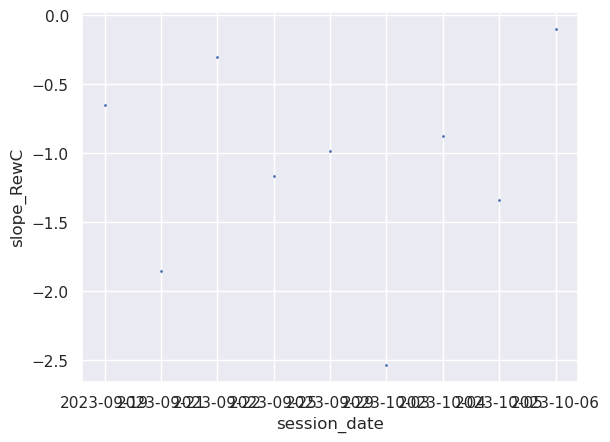

In [47]:
test_subject = 662914

new_slope = slope_df[slope_df['subject_id'] == test_subject]

sns.scatterplot(new_slope, x='session_date', y='slope_RewC', s=5)

In [ ]:
slope_df['subject_id'] = pd.to_numeric(slope_df['subject_id'], errors='coerce')
session_df['subject_id'] = pd.to_numeric(df['subject_id'], errors='coerce')

print(slope_df.dtypes)
print(df.dtypes)

subject_id        int64
session_date     object
slope_RewC      float64
slope_UnrC      float64
dtype: object
trial_back        int64
RewC            float64
UnrC            float64
subject_id       object
session_date     object
dtype: object


In [ ]:
session_df

,subject_id,session_date,nwb_suffix,session,rig,user_name,curriculum_name,curriculum_version,current_stage_actual,task,...,subject_genotype,fiber_probes,injections,task_type,virus,NM_recorded,results,results_location,session_time,docDB_status
0,668551.0,2024-11-06,173429,31.0,447-2-C,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,wt/wt,[],[],Uncoupled Baiting,[],[],behavior_743794_2024-11-06_17-34-29_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/5...,17-34-29,2_uploaded and processed
1,668551.0,2024-11-06,173034,35.0,447-3-D,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,wt/wt,[],[],Uncoupled Baiting,[],[],behavior_741210_2024-11-06_17-30-34_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/b...,17-30-34,2_uploaded and processed
2,668551.0,2024-11-06,172930,31.0,447-3-C,Bowen Tan,Uncoupled Baiting,2.3,GRADUATED,Uncoupled Baiting,...,Oi8(H11-CAG-Cas9)/Oi8(H11-CAG-Cas9),[],[],Uncoupled Baiting,[],[],behavior_728568_2024-11-06_17-29-30_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/1...,17-29-30,2_uploaded and processed
3,668551.0,2024-11-06,172625,11.0,447-1-D,Bowen Tan,Uncoupled Baiting,2.3,STAGE_FINAL,Uncoupled Baiting,...,Drd1a-Cre/wt;Adora2a-T2A-FlpO/wt;Ai231(TICL-Ch...,[],[],Uncoupled Baiting,[],[],behavior_745505_2024-11-06_17-26-25_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/d...,17-26-25,2_uploaded and processed
4,668551.0,2024-11-06,172512,15.0,447-1-C,Bowen Tan,Uncoupled Baiting,2.3,STAGE_FINAL,Uncoupled Baiting,...,Drd1a-Cre/wt;Adora2a-T2A-FlpO/wt;Ai231(TICL-Ch...,[],[],Uncoupled Baiting,[],[],behavior_745502_2024-11-06_17-25-12_processed_...,s3://codeocean-s3datasetsbucket-1u41qdg42ur9/9...,17-25-12,2_uploaded and processed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9078,NaN,2019-06-26,164352,2.0,Training-Tower-2_bpod,Marton Rozsa,NaN,NaN,NaN,Coupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded
9079,NaN,2019-06-25,213144,1.0,Training-Tower-2_bpod,Marton Rozsa,NaN,NaN,NaN,Coupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded
9080,NaN,2019-06-25,201839,1.0,Training-Tower-2_bpod,Marton Rozsa,NaN,NaN,NaN,Coupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded
9081,NaN,2019-06-25,190736,1.0,Training-Tower-2_bpod,Marton Rozsa,NaN,NaN,NaN,Coupled Baiting,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_not uploaded


In [ ]:
master = bu.merge_dataframes_subject_id(session_df, slope_df)

In [ ]:
master

,subject_id,session_date,nwb_suffix,session,rig,user_name,curriculum_name,curriculum_version,current_stage_actual,task,...,injections,task_type,virus,NM_recorded,results,results_location,session_time,docDB_status,slope_RewC,slope_UnrC


In [ ]:
test_slope_df = master[master['subject_id'] == unique_id]

test_slope_df

,subject_id,session_date,nwb_suffix,session,rig,user_name,curriculum_name,curriculum_version,current_stage_actual,task,...,injections,task_type,virus,NM_recorded,results,results_location,session_time,docDB_status,slope_RewC,slope_UnrC


<Axes: xlabel='session', ylabel='slope_RewC'>

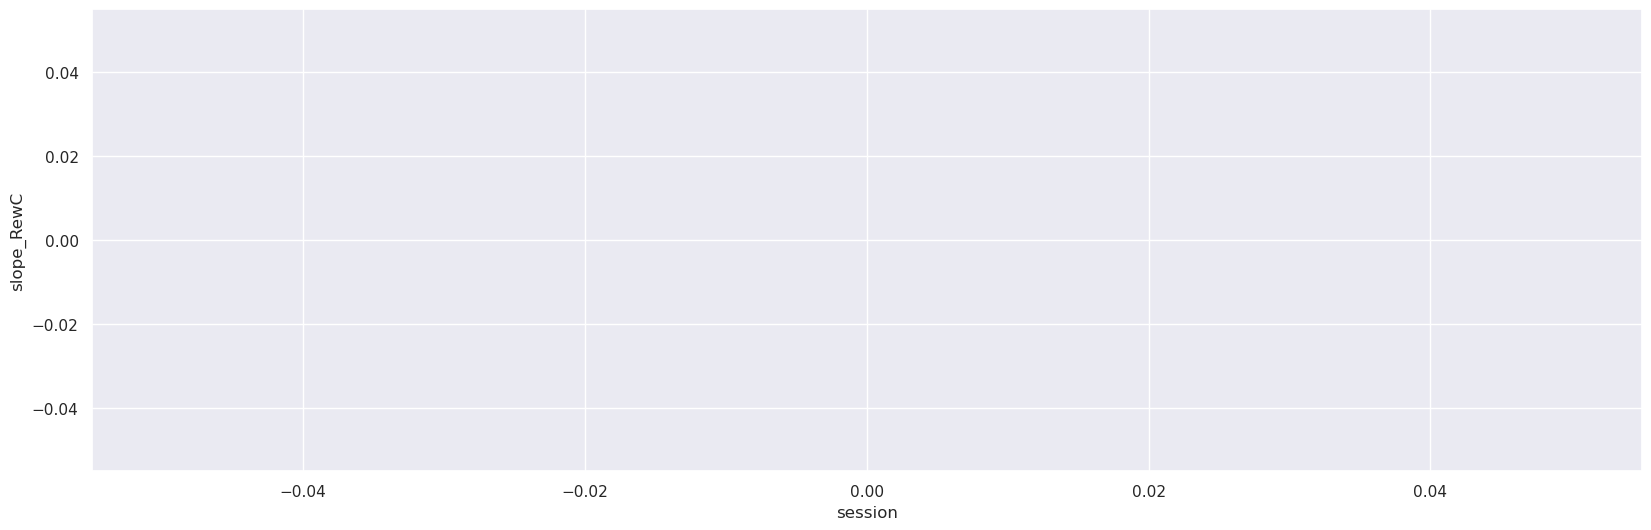

In [ ]:
plt.figure(figsize=(20,6))
sns.lineplot(test_slope_df, x='session', y='slope_RewC')
sns.scatterplot(test_slope_df, x='session', y='slope_RewC', s=1)

In [ ]:
# Loop through parameters find optimal solution 